In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import holidays
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import (GridSearchCV,
                                     TimeSeriesSplit)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import holidays
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import (GridSearchCV,
                                     TimeSeriesSplit)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
from xgboost import plot_importance, plot_tree

c:\Users\augusto.lourencatto\Desktop\me\TCC\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df : pd.DataFrame = pd.read_csv('./data/checkpoints/df_demanda_potencia_v2.csv',index_col='Unnamed: 0')
df.head(2)


,precipitacao_total,pressao_atmosferica,radiacao_global,temperatura_ar,temperatura_ponto_carvalho,umidade_relativa_ar,vento_direcao,velocidade_vento,id_subsistema,nom_subsistema,...,DayOfYear,WeekOfYear,lag_1,lag_7,lag_14,rolling_mean_1,rolling_mean_7,rolling_mean_14,el_nino,la_nina
2012-01-01 00:00:00,0.88,947.22,-2.8518,21.70,19.7,90.25,95.8,1.48,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 01:00:00,2.00,947.30,-2.4346,21.24,19.5,92.00,114.0,0.80,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [3]:
# Interpolando com o metodo de bfill
#TODO: Ver se é o melhor método, e fazer apenas para o valor target
#https://note.nkmk.me/en/python-pandas-interpolate/#:~:text=You%20can%20interpolate%20missing%20values,and%20Series%20with%20interpolate()%20.&text=Use%20dropna()%20and%20fillna,them%20with%20a%20specific%20value.

#bfill preenche com o próximo valor
#ffill preenche com o valor anterior
#spline interpolacao de spline
    #

# df['val_cargaenergiahomwmed'] = df['val_cargaenergiahomwmed'].fillna(method='bfill')
# df['val_cargaenergiahomwmed'] = df['val_cargaenergiahomwmed'].fillna(method='ffill')
df = df.fillna(method='ffill')
# df['val_cargaenergiahomwmed'] = df['val_cargaenergiahomwmed'].interpolate(method='time')

In [4]:
# df['val_cargaenergiahomwmed'].isnull().sum()
df.isnull().sum()

# df['val_cargaenergiahomwmed'][df['val_cargaenergiahomwmed'].isnull()]

precipitacao_total               0
pressao_atmosferica              0
radiacao_global                  0
temperatura_ar                   0
temperatura_ponto_carvalho       0
umidade_relativa_ar              0
vento_direcao                    0
velocidade_vento                 0
id_subsistema                    0
nom_subsistema                   0
val_cargaenergiahomwmed          0
Date                             0
dataref                          0
ano                              0
mes                              0
semana                           0
dia                              0
dia_semana                       0
hora                             0
max_executado                    0
pico                             0
DATE                             0
ORDINAL_DATE                     0
LINREG                           0
Holiday                          0
Quarter                          0
DayOfYear                        0
WeekOfYear                       0
lag_1               

In [5]:
columns_to_drop : list = ["nom_subsistema","id_subsistema","dataref","max_executado","DATE","ORDINAL_DATE","LINREG","dia_semana"]
df.drop(columns_to_drop,axis=1,inplace=True)

In [6]:
df.to_csv("./data/checkpoints/df_final.csv")
df.head()

,precipitacao_total,pressao_atmosferica,radiacao_global,temperatura_ar,temperatura_ponto_carvalho,umidade_relativa_ar,vento_direcao,velocidade_vento,val_cargaenergiahomwmed,Date,...,DayOfYear,WeekOfYear,lag_1,lag_7,lag_14,rolling_mean_1,rolling_mean_7,rolling_mean_14,el_nino,la_nina
2012-01-01 00:00:00,0.88,947.22,-2.8518,21.70,19.700,90.25,95.8,1.48,28212.46,2012-01-01 00:00:00,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 01:00:00,2.00,947.30,-2.4346,21.24,19.500,92.00,114.0,0.80,27511.77,2012-01-01 01:00:00,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 02:00:00,1.24,947.00,-2.3902,21.38,19.775,92.25,159.2,0.62,26339.97,2012-01-01 02:00:00,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 03:00:00,0.44,946.26,-2.2756,21.34,19.425,91.00,178.4,0.46,25318.01,2012-01-01 03:00:00,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 04:00:00,0.32,945.56,-2.2820,21.18,19.775,94.00,116.8,0.32,24543.74,2012-01-01 04:00:00,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [86]:
# df = df['2017-01-01':'2021-12-31']
# df.shape

In [87]:
a

NameError: name 'a' is not defined

In [ ]:
# Dividindo os dados de treino e teste

df_train_xg = df.loc["2012-01-01":"2021-11-31 00:00"]
df_test_xg = df.loc["2021-12-01 00:00":"2021-12-31 23:00"]

print(df_train_xg.shape,df_test_xg.shape)

X_train_xg = df_train_xg.drop(columns=["val_cargaenergiahomwmed"],axis=1)
y_train_xg = df_train_xg["val_cargaenergiahomwmed"]
X_test_xg = df_test_xg.drop(columns=["val_cargaenergiahomwmed"],axis=1)
y_test_xg = df_test_xg["val_cargaenergiahomwmed"]

(43080, 27) (720, 27)


In [ ]:
X_train_xg.to_csv("./data/temp/X_train_xg.csv")
y_train_xg.to_csv("./data/temp/y_train_xg.csv")

In [ ]:
cv = TimeSeriesSplit(n_splits=5)

parameters = {"learning_rate": [0.1, 0.05],
              #The learning rate is the shrinkage you do at every step you are making

               "gamma" : [0.01, 0.1, 0.3, 0.5],
              #A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
              #Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
              
               "max_depth": [2, 4, 7, 10],
              #The maximum depth of a tree, same as GBM.
              #Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.

               "colsample_bytree": [0.3, 0.6],
              #Denotes the fraction of columns to be randomly samples for each tree.

               "subsample": [0.2, 0.4, 0.5],
              #Denotes the fraction of observations to be randomly samples for each tree.
              #Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.

               "reg_alpha": [0, 0.5, 1],
              #L1 regularization term on weights. Increasing this value will make model more conservative.

               "reg_lambda": [1, 1.5, 2, 3, 4.5],
              #L2 regularization term on weights. Increasing this value will make model more conservative.

               "min_child_weight": [1, 3, 5, 7],
              #The larger min_child_weight is, the more conservative the algorithm will be.

               "n_estimators": [100, 250, 500]}
              #Number of tress or rounds. The more, the higher the risk of overfitting

xgbr = xgb.XGBRegressor(objective='reg:squarederror' , sampling_method = 'gradient_based', tree_method = 'gpu_hist')

xgb_rscv = RandomizedSearchCV(xgbr, param_distributions = parameters,  verbose = 3, random_state = 40, cv=cv)

In [ ]:
# Label containes NaN

model_xgboost = xgb_rscv.fit(X_train_xg, y_train_xg)

In [ ]:
model_xgboost.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             gamma=0.3, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=3, sampling_method='gradient_based', scale_pos_weight=1,
             subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             gamma=0.3, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=np.nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=3, sampling_method='gradient_based', scale_pos_weight=1,
             subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)


reg = xgb.XGBRegressor()

In [ ]:
# joblib.dump(reg, "./models/xgboost_v1.joblib.dat")
# loaded_model = joblib.load("./models/xgboost_v1.joblib.dat")

In [ ]:
#MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#Criando uma coluna replica do index
df['Date'] = pd.to_datetime(df.index)
df.drop(columns=['Date'],inplace=True)
df.head()

,precipitacao_total,pressao_atmosferica,radiacao_global,temperatura_ar,temperatura_ponto_carvalho,umidade_relativa_ar,vento_direcao,velocidade_vento,id_subsistema,nom_subsistema,...,DayOfYear,WeekOfYear,lag_1,lag_7,lag_14,rolling_mean_1,rolling_mean_7,rolling_mean_14,el_nino,la_nina
2012-01-01 00:00:00,0.88,947.22,-2.8518,21.70,19.700,90.25,95.8,1.48,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 01:00:00,2.00,947.30,-2.4346,21.24,19.500,92.00,114.0,0.80,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 02:00:00,1.24,947.00,-2.3902,21.38,19.775,92.25,159.2,0.62,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 03:00:00,0.44,946.26,-2.2756,21.34,19.425,91.00,178.4,0.46,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 04:00:00,0.32,945.56,-2.2820,21.18,19.775,94.00,116.8,0.32,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [ ]:
df_completo : pd.DataFrame = df.copy()

df_completo.head()

,precipitacao_total,pressao_atmosferica,radiacao_global,temperatura_ar,temperatura_ponto_carvalho,umidade_relativa_ar,vento_direcao,velocidade_vento,id_subsistema,nom_subsistema,...,DayOfYear,WeekOfYear,lag_1,lag_7,lag_14,rolling_mean_1,rolling_mean_7,rolling_mean_14,el_nino,la_nina
2012-01-01 00:00:00,0.88,947.22,-2.8518,21.70,19.700,90.25,95.8,1.48,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 01:00:00,2.00,947.30,-2.4346,21.24,19.500,92.00,114.0,0.80,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 02:00:00,1.24,947.00,-2.3902,21.38,19.775,92.25,159.2,0.62,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 03:00:00,0.44,946.26,-2.2756,21.34,19.425,91.00,178.4,0.46,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 04:00:00,0.32,945.56,-2.2820,21.18,19.775,94.00,116.8,0.32,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [ ]:
import datetime as dt
from datetime import timedelta

def expandingWindowDiario(df : pd.DataFrame, test_start_date : dt, stop_date : dt):
  mae_modelo = []
  mape_modelo = []
  column_names = ["Date", "val_cargaenergiahomwmed"	,"EXECUTADO_MODELO"]
  df_previsao = pd.DataFrame(columns = column_names)
  # train_start_date = dt.datetime(2012,1,1,0,0,0)
  train_start_date = dt.datetime(2012,1,1,0,0,0)
  train_end_date = test_start_date
  test_end_date = test_start_date + timedelta(hours = 24)

  df.index = pd.to_datetime(df.index)

  while test_start_date < stop_date:

    print("TRAIN:",train_start_date," - ",train_end_date)
    print("TEST:",test_start_date," - ",test_end_date)

    df_train=df.loc[train_start_date:train_end_date].copy()
    df_test=df.loc[test_start_date:test_end_date].copy()

    columns_to_drop : list = ["val_cargaenergiahomwmed","nom_subsistema","id_subsistema","dataref","max_executado","DATE","ORDINAL_DATE","LINREG","dia_semana"]

    X_training = df_train.drop(columns=columns_to_drop).copy()
    y_training = df_train["val_cargaenergiahomwmed"].copy()
    X_test = df_test.drop(columns=columns_to_drop).copy()
    y_test = df_test["val_cargaenergiahomwmed"].copy()

    reg.fit(X_training, y_training,
          verbose=False)
    yhat = reg.predict(X_test)

    #Erro
    maeTeste = mean_absolute_error(y_test,yhat)
    mae_modelo.append(maeTeste)
    mape_teste = mean_absolute_percentage_error(y_test,yhat)
    mape_modelo.append(mape_teste)
    d = {'Date' :y_test.index ,'Real':y_test,'Modelo':yhat}
    previsao = pd.DataFrame(data=d)
    df_previsao=df_previsao.append(previsao)

    #Avança
    train_end_date = train_end_date + timedelta(days = 1)
    test_start_date = test_start_date + timedelta(days = 1)
    test_end_date = test_end_date + timedelta(days = 1)

  return ([df_previsao,mae_modelo, mape_modelo])
  # return 1,1,1

# df_train_xg = df.loc["2012-01-01":"2020-31-12 00:00"]
# df_test_xg = df.loc["2021-01-01 00:00":"2021-12-31 23:00"]



# df_previsao,mae_full,mape_full = expandingWindowDiario(df_completo,dt.datetime(2021,1,1,0,0,0),dt.datetime(2021,12,31,0,0,0))



# dt.datetime(2021,1,1,0,0,0)

In [ ]:
y_train_xg.head(2)

2012-01-01 00:00:00    28212.46
2012-01-01 01:00:00    27511.77
Name: val_cargaenergiahomwmed, dtype: float64

In [ ]:
reg.fit(X_train_xg, y_train_xg,
          verbose=False)

c:\Users\augusto.lourencatto\Desktop\me\TCC\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
yhat = reg.predict(X_test_xg)
maeTeste = mean_absolute_error(y_test_xg,yhat)
mape_teste = mean_absolute_percentage_error(y_test_xg,yhat)
maeTeste,mape_teste

(1078.4920700959444, 2.8555356499087163)

In [ ]:
%%time
#Sem rooling windows
y_true, y_pred = np.array(y_test_xg), np.array(yhat)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape

CPU times: total: 0 ns
Wall time: 1.05 ms


2.8555356499087163

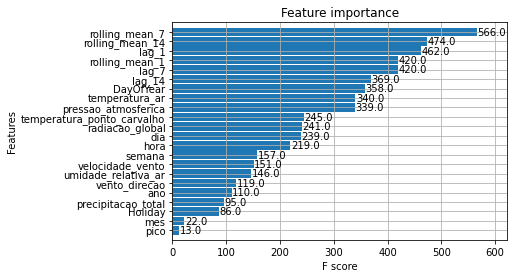

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

rf_regressor.fit(X_train_xg, y_train_xg)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').